In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from importlib import reload

import xarray as xr
import xnemogcm as xn
import xgcm

from pyCDFTOOLS import analysis, in_out
import matplotlib.pyplot as plt
import numpy as np

reload(analysis)
reload(in_out)

<module 'pyCDFTOOLS.in_out' from '/home/jclmak/Documents/GitRepo/pyCDFTOOLS_xgcm/brainfart_logs/../pyCDFTOOLS/in_out.py'>

In [2]:
# try opening
base_dir = "/home/jclmak/data/NEMO_data/UNAGI/EXP_R025/"  # mesh_mask lives here
data_dir = base_dir + "split_100km/alp0060_lam80/tau100x/OUTPUTS/"

domcfg = xn.open_domain_cfg(base_dir)

# opening file already in _grid_T.nc convention; going to load everything into one object
ds = xn.open_nemo_and_domain_cfg(
    domcfg_files=base_dir,
    nemo_files=[data_dir + "UNAGI_10y_08010101_08101230_grid_T.nc"]
)

# open files not in the _grid_T.nc convention (note domcfg goes AFTER positions here)
ds_1 = xn.process_nemo(
    positions=[
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_T.nc"), 'T'),
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_U.nc"), 'U'),
        (xr.open_dataset(data_dir + "UNAGI_1y_08010101_08101230_surf_V.nc"), 'V'),
    ],
    domcfg=domcfg,
)

# could merge into one if you want (depends if you want multiple objects floating around)
ds = ds.merge(ds_1, compat="override")
del ds_1  # free up the object

In [3]:
# generate the grid object

Static_e3 = True
metrics_dict = xn.get_metrics(ds)
if Static_e3:
    metrics_dict[('Z',)] = ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0', 'e3w_0']

# tidy up of metrics: EW peridicity seems to screw up the metrics at the perodic points in NEMO4.0 leading to
#                     divide by zeros, just add it back in

for points in ["t", "u", "v", "f"]:
    ds[f"e1{points}"][:,  0] = ds[f"e1{points}"][:,  1].values
    ds[f"e1{points}"][:, -1] = ds[f"e1{points}"][:,  0].values
    ds[f"e2{points}"][:,  0] = ds[f"e2{points}"][:,  1].values
    ds[f"e2{points}"][:, -1] = ds[f"e2{points}"][:,  0].values
    
    ds[f"e3{points}_0"][:,  0] = ds[f"e3{points}_0"][:,  1].values
    ds[f"e3{points}_0"][:, -1] = ds[f"e3{points}_0"][:,  0].values
    
grid = xgcm.Grid(ds, metrics=metrics_dict, periodic=["X"])  # specify periodicity with a list

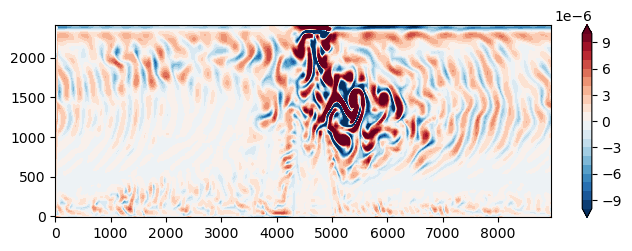

In [4]:
bd = {'boundary':'fill', 'fill_value':0}
# there are NaN's in the data for some reason...?
xi = analysis.cdfcurl(grid, ds, ds.ssu_inst, ds.ssv_inst, **bd)

fig = plt.figure(figsize=(8, 2.5))
ax = plt.axes()
cs = ax.contourf(xi.glamf[:, :-1], xi.gphif[:, :-1], xi[2, :, :-1],
                 levels=np.linspace(-1e-5, 1e-5, 21), cmap="RdBu_r", extend="both")
plt.colorbar(cs)

In [5]:
# test write of data (promote to dataset first)
in_out.save_netcdf(xi)

variable name socurl, output to socurl.nc
